In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..")
from utils import data_dir

from tqdm import tqdm
from tabulate import tabulate

In [122]:
task_name = "axion2"
model_layer = "F_7"

## Grab our data

In [123]:
pfn_outputs = np.load(f"pfn_layer_outputs/{task_name}_{model_layer}_10%.npy")
pfn_outputs = pfn_outputs.T

# Stylize these labels for the sake of LaTeX
if "_" in model_layer:
    part, idx = model_layer.split("_")  # Something like ("F", "7")
    model_layer = f"{part}{idx}"
pfn_labels = [f"{model_layer}({i})" for i in range(pfn_outputs.shape[0])]

print("PFN outputs shape:", pfn_outputs.shape)

PFN outputs shape: (128, 30000)


In [191]:
bdt_vars = []
for particle in ["pi0", "gamma", task_name]:
    bdt_var_npz = np.load(f"{data_dir}/processed/bdt_vars/{particle}_bdt_vars.npz")
    bdt_var_labels = list(bdt_var_npz.keys())
    bdt_vars.append(np.vstack([bdt_var_npz[key] for key in bdt_var_labels])[:,::10])

bdt_vars = np.hstack(bdt_vars)
print("BDT vars shape: ", bdt_vars.shape)

BDT vars shape:  (53, 30000)


In [192]:
# Mask out things that are all zeros
def filter_zero_var(arr, labels):
    """
    arr.shape == (n_features, n_samples)
    len(labels) == n_features
    
    Filter out all features having zero variance.
    """
    # Filter for zero variance
    all_zero_mask = np.nanvar(arr, axis=1) < 1e-6
    return (
        arr[~all_zero_mask],
        [labels[i] for i in np.where(~all_zero_mask)[0]],
        all_zero_mask
    )

pfn_outputs, pfn_labels, _ = filter_zero_var(pfn_outputs, pfn_labels)
bdt_vars, bdt_var_labels, _ = filter_zero_var(bdt_vars, bdt_var_labels)

In [193]:
all_vars = np.vstack([pfn_outputs, bdt_vars])
all_labels = pfn_labels + bdt_var_labels

# Impute missing values
nan_locs = np.where(np.isnan(all_vars))
for feature, sample in zip(*nan_locs):
    all_vars[feature,sample] = np.nanmean(all_vars[feature,:])
    
assert not np.any(np.isnan(all_vars))

In [194]:
print(all_vars.shape)

(162, 30000)


## Evaluate correlations

In [183]:
# Wooooo...
corr_mat = np.corrcoef(all_vars)

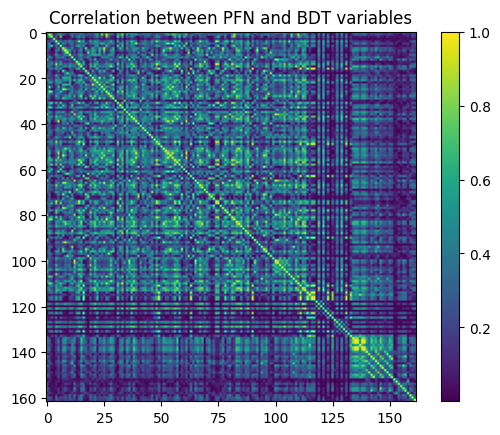

In [184]:
plt.imshow(np.abs(corr_mat))
plt.colorbar()
plt.title(f"Correlation between PFN and BDT variables");

There's a couple variables with zero variance amongst the BDT variables, but that's ok.

In [185]:
def corr(var1, var2):
    return corr_mat[all_labels.index(var1),all_labels.index(var2)]

In [250]:
# Stylize labels with LaTeX
def stylize(label):
    if label.startswith("F"):
        if len(label) > 2:  # Unit
            F_layer = label[1]
            unit_idx = label[3:-1]
            return "$F^{[" + F_layer + "]}_{" + unit_idx + "}$"
        else:
            F_layer = label[1]
            return "$F^{[" + F_layer + "]}$"
    return label

In [273]:
def plot_corr(var1, var2, title=True):
    idx1, idx2 = all_labels.index(var1), all_labels.index(var2)
    plt.scatter(all_vars[idx1], all_vars[idx2], s=0.2, linewidth=0)
    
    plt.xlabel(stylize(var1))
    plt.ylabel(stylize(var2))
    if title: plt.title(f"{task_name} PFN, layer {stylize(model_layer)}")

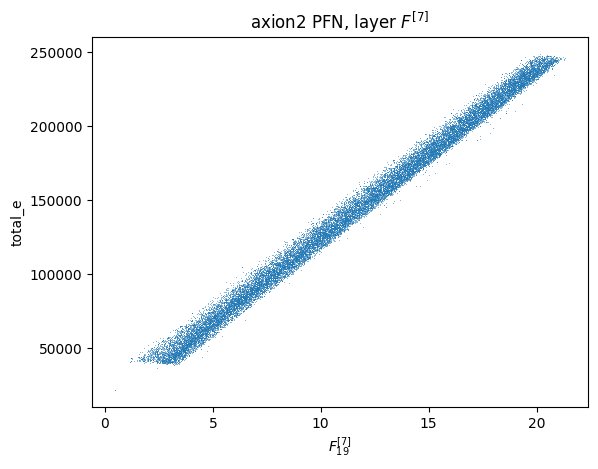

In [274]:
plot_corr("F7(19)", "total_e")

## For each PFN variable, find which BDT var it correlates most highly with

In [255]:
table = []

for var1 in pfn_labels:
    idx1 = all_labels.index(var1)
    idx2 = np.argmax(corr_mat[idx1,len(pfn_labels):]) + len(pfn_labels)
    var2 = all_labels[idx2]
    corr = corr_mat[idx1,idx2]
    table.append([stylize(var1), var2, corr])

table.sort(key=lambda row: -abs(row[2]))

# Top 9
print(tabulate(
    table[:9],
    headers=["PFN unit", "BDT variable", "correlation"],
    tablefmt="latex_raw"
))

\begin{tabular}{llr}
\hline
 PFN unit        & BDT variable           &   correlation \\
\hline
 $F^{[7]}_{73}$  & depth_weighted_total_e &      0.998948 \\
 $F^{[7]}_{106}$ & depth_weighted_total_e &      0.99636  \\
 $F^{[7]}_{19}$  & total_e                &      0.996346 \\
 $F^{[7]}_{59}$  & secondlayer_e          &      0.991736 \\
 $F^{[7]}_{96}$  & firstlayer_x2          &      0.907271 \\
 $F^{[7]}_{99}$  & firstlayer_x2          &      0.890862 \\
 $F^{[7]}_{121}$ & firstlayer_y2          &      0.886877 \\
 $F^{[7]}_{126}$ & prelayer_e             &      0.876291 \\
 $F^{[7]}_{95}$  & prelayer_e             &      0.870709 \\
\hline
\end{tabular}


In [258]:
pairs = [
    ("F7(73)", "depth_weighted_total_e"),
    ("F7(73)", "total_e"),
    ("F7(19)", "total_e"),
    ("F7(59)", "secondlayer_e"),
    ("F7(96)", "firstlayer_x2"),
    ("F7(121)", "firstlayer_y2"),
    ("F7(126)", "prelayer_e")
]

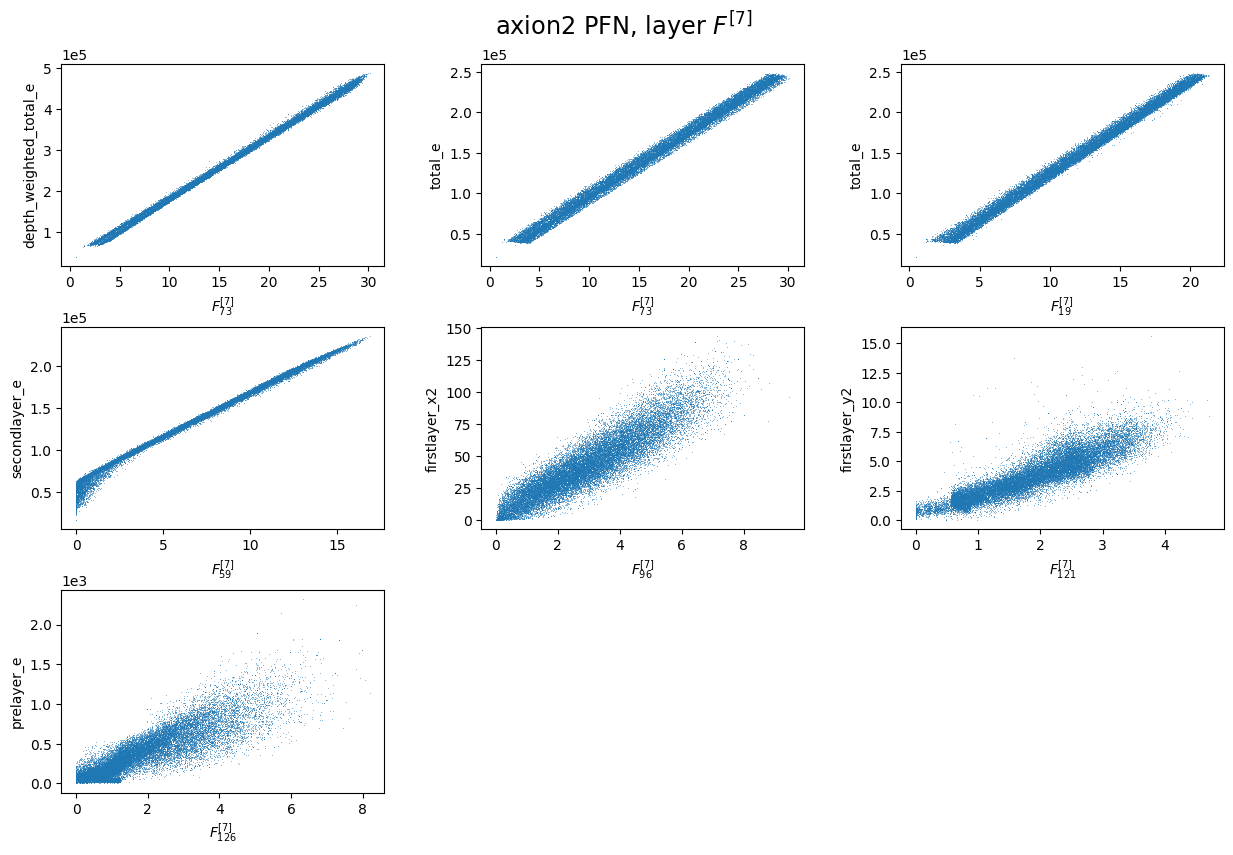

In [308]:
n_cols = 3
n_rows = -(-len(pairs) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3*n_rows))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
plt.suptitle(f"{task_name} PFN, layer {stylize(model_layer)}", fontsize="xx-large")
# plt.tight_layout()

# https://stackoverflow.com/questions/8248467/tight-layout-doesnt-take-into-account-figure-suptitle
plt.subplots_adjust(top=0.92)

for row in range(n_rows):
    for col in range(n_cols):
        i = row*n_cols + col        
        if i < len(pairs):
            pair = pairs[i]
            var1, var2 = pair
            plt.axes(axes[i//n_cols,i%n_cols])            
            plt.ticklabel_format(axis="y", style="sci", scilimits=(0,3))
            plot_corr(var1, var2, title=False)
        else:
            fig.delaxes(axes[row,col])